In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

import astropy.coordinates as coord
from astropy.table import Table
from astropy.io import fits
import astropy.units as u

from scipy.optimize import minimize
import scipy.stats
import sklearn.mixture as sm

import myutils
from pyia import GaiaData

In [2]:
plt.style.use('notebook')

In [3]:
R = np.load('../data/jhelum_rotmat_init.npy')
from astropy.coordinates import frame_transform_graph
from astropy.coordinates.matrix_utilities import matrix_transpose

class Jhelum(coord.BaseCoordinateFrame):
    """
    A Heliocentric spherical coordinate system defined by the track of the PS1-A stream

    For more information about this class, see the Astropy documentation
    on coordinate frames in :mod:`~astropy.coordinates`.

    Parameters
    ----------
    representation : :class:`~astropy.coordinates.BaseRepresentation` or None
        A representation object or None to have no data (or use the other keywords)

    phi1 : angle_like, optional, must be keyword
        The longitude-like angle corresponding to Orphan's orbit.
    phi2 : angle_like, optional, must be keyword
        The latitude-like angle corresponding to Orphan's orbit.
    distance : :class:`~astropy.units.Quantity`, optional, must be keyword
        The Distance for this object along the line-of-sight.

    pm_phi1_cosphi2 : :class:`~astropy.units.Quantity`, optional, must be keyword
        The proper motion in the longitude-like direction corresponding to
        the Orphan stream's orbit.
    pm_phi2 : :class:`~astropy.units.Quantity`, optional, must be keyword
        The proper motion in the latitude-like direction perpendicular to the
        Orphan stream's orbit.
    radial_velocity : :class:`~astropy.units.Quantity`, optional, must be keyword
        The Distance for this object along the line-of-sight.

    """
    default_representation = coord.SphericalRepresentation
    default_differential = coord.SphericalCosLatDifferential

    frame_specific_representation_info = {
        coord.SphericalRepresentation: [
            coord.RepresentationMapping('lon', 'phi1'),
            coord.RepresentationMapping('lat', 'phi2'),
            coord.RepresentationMapping('distance', 'distance')],
        coord.SphericalCosLatDifferential: [
            coord.RepresentationMapping('d_lon_coslat', 'pm_phi1_cosphi2'),
            coord.RepresentationMapping('d_lat', 'pm_phi2'),
            coord.RepresentationMapping('d_distance', 'radial_velocity')],
        coord.SphericalDifferential: [
            coord.RepresentationMapping('d_lon', 'pm_phi1'),
            coord.RepresentationMapping('d_lat', 'pm_phi2'),
            coord.RepresentationMapping('d_distance', 'radial_velocity')]
    }

    frame_specific_representation_info[coord.UnitSphericalRepresentation] = \
        frame_specific_representation_info[coord.SphericalRepresentation]
    frame_specific_representation_info[coord.UnitSphericalCosLatDifferential] = \
        frame_specific_representation_info[coord.SphericalCosLatDifferential]
    frame_specific_representation_info[coord.UnitSphericalDifferential] = \
        frame_specific_representation_info[coord.SphericalDifferential]


@frame_transform_graph.transform(coord.StaticMatrixTransform, coord.ICRS, Jhelum)
def icrs_to_jhelum():
    """ Compute the transformation from Galactic spherical to
        heliocentric Jhelum coordinates.
    """
    return R

@frame_transform_graph.transform(coord.StaticMatrixTransform, Jhelum, coord.ICRS)
def jhelum_to_icrs():
    """ Compute the transformation from heliocentric Jhelum coordinates to
        spherical Galactic.
    """
    return matrix_transpose(icrs_to_jhelum())

In [4]:
t = Table(fits.getdata('../data/jhelum_des.fits'))

In [5]:
g = GaiaData(t)
c = coord.SkyCoord(ra=g.ra, dec=g.dec,
                   pm_ra_cosdec=g.pmra, pm_dec=g.pmdec)

In [11]:
wangle = 180*u.deg
distance_app = 12.8*u.kpc
def jhelum_dist(phi1, d0=distance_app.to(u.kpc).value, d1=0, d2=0):
    p1, p2 = 0, 20
    if (d1==0) | (d2==0):
        d1, d2 = d0, d0
    m = (d2-d1) / (p1-p2)
    return (m*phi1.wrap_at(wangle).value + d1) * u.kpc

In [9]:
cj = c.transform_to(Jhelum)
cj_noreflex = c.transform_to(Jhelum)
cj_dist = Jhelum(phi1=cj.phi1, phi2=cj.phi2,
                    distance=jhelum_dist(cj.phi1),
                    pm_phi1_cosphi2=cj.pm_phi1_cosphi2,
                    pm_phi2=cj.pm_phi2,
                    radial_velocity=[0]*len(cj)*u.km/u.s)

# Correct for reflex motion
v_sun = coord.Galactocentric.galcen_v_sun
observed = cj_dist.transform_to(coord.Galactic)
rep = observed.cartesian.without_differentials()
rep = rep.with_differentials(observed.cartesian.differentials['s'] + v_sun)
cj = coord.Galactic(rep).transform_to(Jhelum)

In [10]:
iso = Table.read('../data/mist_12.0_-1.50.cmd', format='ascii.commented_header', header_start=12)
phasecut = (iso['phase']>=0) & (iso['phase']<5)
iso = iso[phasecut]

In [12]:
# distance modulus
dm = 5*np.log10((distance_app.to(u.pc)).value)-5

# main sequence + rgb
i_gi = iso['DECam_g']-iso['DECam_i'] + 0.05
i_g = iso['DECam_g']+dm

i_left = i_gi - 0.4*(i_g/28)**5
i_right = i_gi + 0.55*(i_g/28)**5

poly = np.hstack([np.array([i_left, i_g]), np.array([i_right[::-1], i_g[::-1]])]).T
ind = (poly[:,1]<21.3) & (poly[:,1]>19)
poly_main = poly[ind]

In [36]:
points = np.array([g.g0 - g.i0, g.g0]).T
path_main = mpl.path.Path(poly_main)
cmd_mask = path_main.contains_points(points)

pm1_min = -8*u.mas/u.yr
pm1_max = -4*u.mas/u.yr
pm2_min = -2*u.mas/u.yr
pm2_max = 2.*u.mas/u.yr
pm_mask = ((cj.pm_phi1_cosphi2 < pm1_max) & (cj.pm_phi1_cosphi2 > pm1_min) & 
           (cj.pm_phi2 < pm2_max) & (cj.pm_phi2 > pm2_min))

bhb_gi_min = -1
bhb_gi_max = -0.2
bhb_g_min = 15.5
bhb_g_max = 16.5

bhb_mask = (g.g0-g.i0<bhb_gi_max) & (g.g0-g.i0>bhb_gi_min) & (g.g0<bhb_g_max) & (g.g0>bhb_g_min)

In [ ]:
# BHB distance spread

In [37]:
def bhb_distance(g, gr):
    """Return distance to BHB stars, assuming absolute magnitudes from Deason et al. (2011)"""
    
    Mg = (0.434 - 0.169*gr + 2.319*gr**2 + 20.449*gr**3 + 94.517*gr**4)
    d = np.array(10**(1 + 0.2*(g - Mg)))*u.pc
    
    return d.to(u.kpc)

In [39]:
narrow_mask = ((cj.phi2<1*u.deg) & (cj.phi2>0.5*u.deg) & 
               (cj.phi1.wrap_at(wangle)<23*u.deg) & (cj.phi1.wrap_at(wangle)>-5*u.deg))

In [40]:
bhb_distances = bhb_distance(g.g0[bhb_mask & pm_mask & narrow_mask], 
                             g.g0[bhb_mask & pm_mask & narrow_mask] - g.r0[bhb_mask & pm_mask & narrow_mask])

In [42]:
sigma_dist = np.std(bhb_distances)

In [14]:
def mad_std(x):
    """Median absolute deviation"""
    return 1.5 * np.median(np.abs(np.median(x)-x))

In [15]:
# setup bins for finding track
bin_size = 4 # deg
bin_l = np.arange(-5, (30-bin_size)+1, 2.)
bin_r = bin_l + bin_size
bin_c = 0.5 * (bin_l+bin_r)

bins_nonoverlap = np.arange(-5, (30-bin_size)+1, bin_size)
cen_phi1 = 0.5 * (bins_nonoverlap[:-1] + bins_nonoverlap[1:])

In [16]:
# median track
stream_mask = pm_mask & cmd_mask
phi2_wide_mask = stream_mask & (cj.phi2 < 2.*u.deg) & (cj.phi2 > -3.*u.deg)

phi2_median, be, bn = scipy.stats.binned_statistic((cj.phi1[phi2_wide_mask]).wrap_at(wangle).degree, 
                                       cj.phi2[phi2_wide_mask].degree, 
                                       statistic='median', bins=bins_nonoverlap)
phi2_sum, be = np.histogram((cj.phi1[phi2_wide_mask]).wrap_at(wangle).degree, 
                            bins=bins_nonoverlap)
phi2_median_err = np.abs(phi2_median) / np.sqrt(phi2_sum)

deg = 2
ptrack = np.polyfit(cen_phi1, phi2_median, deg, w=1 / np.sqrt(phi2_sum))

polytrack = np.poly1d(ptrack)
phi1_ = np.linspace(-5, 30, 100)
phi2_ = polytrack(phi1_)

In [17]:
# set up running median bins, arrays
bin_size = 1 # deg
bin_l = np.arange(-5, (30-bin_size)+1, 1.)
bin_r = bin_l + bin_size
bins_phi1 = 0.5 * (bin_l+bin_r)

Nbins = len(bin_l)
n = np.zeros(Nbins)
n_back = np.zeros(Nbins)
w = np.zeros(Nbins)*u.deg
rmed_phi2 = np.zeros(Nbins)*u.deg
rmed_p = np.zeros(Nbins)*u.mas
rmed_pmphi1 = np.zeros(Nbins)*u.mas/u.yr
rmed_pmphi2 = np.zeros(Nbins)*u.mas/u.yr
rmed_p_err = np.zeros(Nbins)*u.mas
rmed_pmphi1_err = np.zeros(Nbins)*u.mas/u.yr
rmed_pmphi2_err = np.zeros(Nbins)*u.mas/u.yr

In [44]:
# stream track properties
phi2_poly = polytrack(cj.phi1[pm_mask & cmd_mask].wrap_at(180*u.deg))
off_phi2 = 3
delta_phi2 = 1.5
_phi1 = cj.phi1[pm_mask & cmd_mask].wrap_at(180*u.deg).degree

for i, l, r in zip(range(Nbins), bin_l, bin_r):
    sel_bin = (_phi1 > l) & (_phi1 <= r)
    sel_stream = (np.abs(cj.phi2[pm_mask & cmd_mask].to(u.deg).value - phi2_poly) < delta_phi2)
    sel_back = ((np.abs(cj.phi2[pm_mask & cmd_mask].to(u.deg).value - phi2_poly - off_phi2)<delta_phi2) |
                (np.abs(cj.phi2[pm_mask & cmd_mask].to(u.deg).value - phi2_poly + off_phi2)<delta_phi2))
    selection = sel_bin & sel_stream
    
    n[i] = np.sum(selection)
    n_back[i] = np.sum(sel_bin & sel_back) * 0.5
    
    rmed_phi2[i] = np.nanmedian(cj.phi2[pm_mask & cmd_mask][selection])
    w[i] = mad_std(cj.phi2[pm_mask & cmd_mask][selection])
    
    rmed_p[i] = np.nanmedian(g.parallax[pm_mask & cmd_mask][selection])
    rmed_p_err[i] = mad_std(g.parallax[pm_mask & cmd_mask][selection])
    
    rmed_pmphi1[i] = np.nanmedian(cj_noreflex.pm_phi1_cosphi2[pm_mask & cmd_mask][selection])
    rmed_pmphi1_err[i] = mad_std(cj_noreflex.pm_phi1_cosphi2[pm_mask & cmd_mask][selection])
    
    rmed_pmphi2[i] = np.nanmedian(cj_noreflex.pm_phi2[pm_mask & cmd_mask][selection])
    rmed_pmphi2_err[i] = mad_std(cj_noreflex.pm_phi2[pm_mask & cmd_mask][selection])
    
density = (n-n_back)/(2*delta_phi2*bin_size)

med_dist = np.ones_like(bins_phi1) * distance_app
med_dist_err = np.ones_like(bins_phi1) * sigma_dist

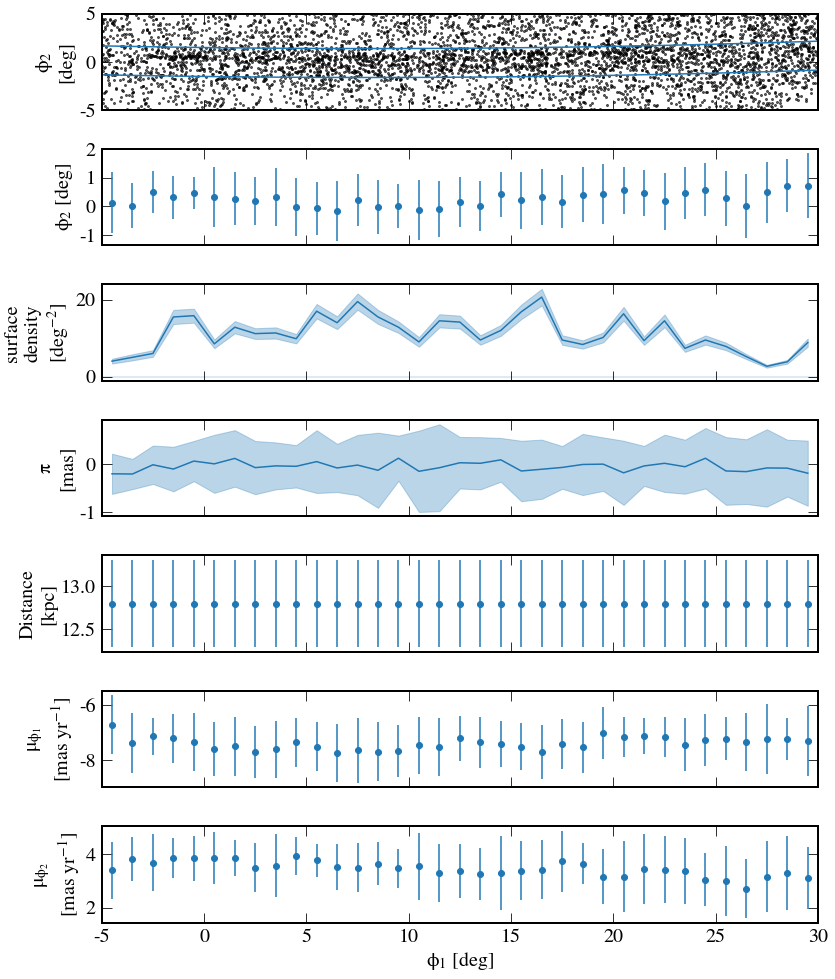

In [45]:
fig, ax = plt.subplots(7, 1, figsize=(12,14), sharex=True)

plt.sca(ax[0])
plt.plot(cj.phi1[pm_mask & cmd_mask].wrap_at(wangle), 
        cj.phi2[pm_mask & cmd_mask], 
        'ko', ms=2, alpha=0.6, rasterized=True)

plt.plot(phi1_, phi2_+delta_phi2, '-', color='tab:blue')
plt.plot(phi1_, phi2_-delta_phi2, '-', color='tab:blue')
plt.ylabel('$\phi_2$\n[deg]')
plt.ylim(-5, 5)

plt.sca(ax[1])
plt.errorbar(bins_phi1, rmed_phi2.value, yerr=w.value, fmt='o', color='tab:blue')
plt.ylabel('$\phi_2$ [deg]')

plt.sca(ax[2])
plt.plot(bins_phi1, density, '-', label='data')
plt.fill_between(bins_phi1, density*(1-1/np.sqrt(n)), density*(1+1/np.sqrt(n)), 
                color='tab:blue', alpha=0.3)
plt.axhline(0, zorder=-10, alpha=0.2)
plt.ylabel('surface\ndensity\n[deg$^{-2}$]')

# parallax track
plt.sca(ax[3])
plt.plot(bins_phi1, rmed_p, '-')
plt.fill_between(bins_phi1, rmed_p-rmed_p_err, rmed_p+rmed_p_err, 
                color='tab:blue', alpha=0.3)
plt.ylabel('$\pi$\n[mas]')

plt.sca(ax[4])
plt.errorbar(bins_phi1, med_dist.value, yerr=med_dist_err.value, fmt='o', color='tab:blue')
plt.ylabel('Distance\n[kpc]')

plt.sca(ax[5])
plt.errorbar(bins_phi1, rmed_pmphi1.value, yerr=rmed_pmphi1_err.value, fmt='o', color='tab:blue')
plt.ylabel('$\mu_{\phi_1}$\n[mas yr$^{-1}$]')

plt.sca(ax[6])
plt.errorbar(bins_phi1, rmed_pmphi2.value, yerr=rmed_pmphi2_err.value, fmt='o', color='tab:blue')
plt.xlabel('$\phi_1$ [deg]')
plt.ylabel('$\mu_{\phi_2}$\n[mas yr$^{-1}$]')

plt.xlim(-5, 30)

fig.tight_layout()

In [46]:
tout = Table([bins_phi1, rmed_phi2, w, med_dist, med_dist_err, rmed_pmphi1, rmed_pmphi1_err, 
              rmed_pmphi2, rmed_pmphi2_err],
             names=('phi1', 'phi2', 'w', 'dist', 'dist_err', 'pm1', 'pm1_err', 'pm2', 'pm2_err'))

In [48]:
phi1_mask = (bins_phi1>-3) & (bins_phi1<25)
tout[phi1_mask].write('../data/jhelum_track.fits')